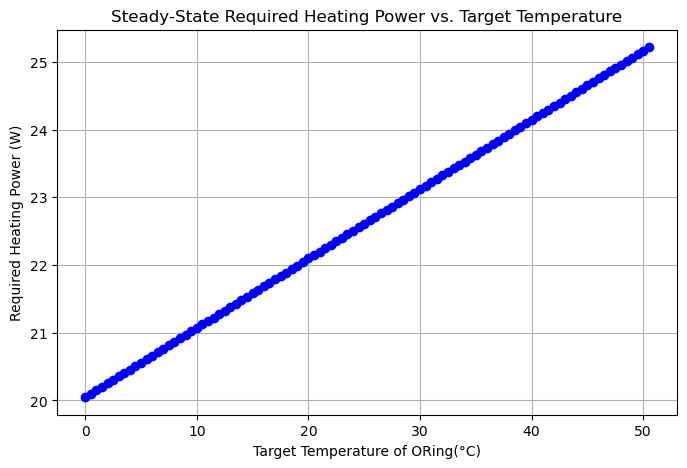

Heating Power at 19°C: 21.9913 W
Heating Power at 20°C: 22.0969 W
Heating Power at 21°C: 22.1992 W


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# Geometry and Discretization
# =============================================================================
L = 0.101      # [m] Total vertical extent (sphere diameter = 101 mm)
n = 50         # Number of spatial points
dx = L / (n - 1)

# =============================================================================
# Material Properties (Stainless Steel)
# =============================================================================
k = 16.2            # [W/m·K] thermal conductivity
rho = 7800.0        # [kg/m³] density
cp = 500.0          # [J/kg·K] specific heat
alpha = k / (rho * cp)  # [m²/s] thermal diffusivity

# =============================================================================
# Time-Stepping Parameters
# =============================================================================
dt = 0.5         # [s] time step (ensures stability dt <= dx²/(2α))
max_iterations = 10000  # Max iterations for steady-state convergence
tolerance = 1e-5  # Convergence threshold

# =============================================================================
# Boundary Conditions - Three-Region Model
# =============================================================================
# Fractions along the vertical extent
f_LN2 = 30 / 101   # LN2 immersion (30 mm)
f_cold = 20 / 101  # Cold air region (20 mm)
f_amb = 51 / 101   # Ambient region (51 mm)

# Region Temperatures (°C)
T_LN2  = -196.0    # Liquid nitrogen temperature
T_cold = -80.0     # Cold air temperature
T_amb  = 22.0      # Ambient temperature

# Convection Coefficients (W/m²·K)
h_LN2  = 4.827e4   # LN2 experimental value
h_cold = 10.0      # Cold air convection
h_amb  = 10.0      # Ambient air convection

# =============================================================================
# Compute Corrected Effective Values
# =============================================================================
# Corrected Effective Convection Coefficient (Weighted Sum for Parallel Paths)
h_eff = f_LN2 * h_LN2 + f_cold * h_cold + f_amb * h_amb

# Corrected Effective Temperature (Weighted Average Based on Heat Transfer)
T_eff = (f_LN2 * h_LN2 * T_LN2 + f_cold * h_cold * T_cold + f_amb * h_amb * T_amb) / \
        (f_LN2 * h_LN2 + f_cold * h_cold + f_amb * h_amb)

# =============================================================================
# Heating Strip Geometry (for computing total power later)
# =============================================================================
inch = 0.0254
A_strip = inch * inch  # [m²]

# =============================================================================
# Simulation for Different Target Temperatures
# =============================================================================
start = 0
stop = 51
target_temperatures = np.arange(start, stop, 0.5)  
steady_state_heating_powers = []

if dt > dx**2 / (2 * alpha):
    print("Warning: Time step (dt) may cause instability in the explicit method.")

# Time-stepping loop for each target temperature
for T_target in target_temperatures:
    # Initialize temperature profile
    T = np.linspace(T_eff, T_amb, n)  # Initial temperature condition

    for _ in range(max_iterations):
        T_new = T.copy()

        # Update interior nodes using explicit finite-difference scheme
        for i in range(1, n - 1):
            T_new[i] = T[i] + dt * alpha * (T[i - 1] - 2 * T[i] + T[i + 1]) / dx**2

        # Apply boundary conditions
        # Bottom boundary: Robin condition (convective cooling to LN2 and air)
        T_new[0] = (T_new[1] + (dx * h_eff / k) * T_eff) / (1 + dx * h_eff / k)

        # Top boundary: Enforce fixed temperature condition (Dirichlet BC)
        T_new[-1] = T_target

        # Check for steady-state (convergence)
        if np.max(np.abs(T_new - T)) < tolerance:
            break  # Stop iteration if temperature change is negligible

        T[:] = T_new  # Update temperature for next iteration

    # Compute the heating power after reaching steady-state
    q_heater = k * abs(T[-2] - T_target) / dx  # Heat flux [W/m²]
    Q_heater = A_strip * q_heater  # Total heating power [W]

    steady_state_heating_powers.append(Q_heater)  # Store result

# =============================================================================
# Plot Corrected Heating Power After Steady-State
# =============================================================================
plt.figure(figsize=(8, 5))
plt.plot(target_temperatures, steady_state_heating_powers, marker='o', linestyle='-', color='blue')
plt.xlabel("Target Temperature of ORing(°C)")
plt.ylabel("Required Heating Power (W)")
plt.title("Steady-State Required Heating Power vs. Target Temperature")
plt.grid(True)
plt.show()

print(f"Heating Power at 19°C: {steady_state_heating_powers[38]:.4f} W")
print(f"Heating Power at 20°C: {steady_state_heating_powers[40]:.4f} W")
print(f"Heating Power at 21°C: {steady_state_heating_powers[42]:.4f} W")

Simulating for Target Temperatures (2D): 100%|██████████| 102/102 [01:58<00:00,  1.16s/it]


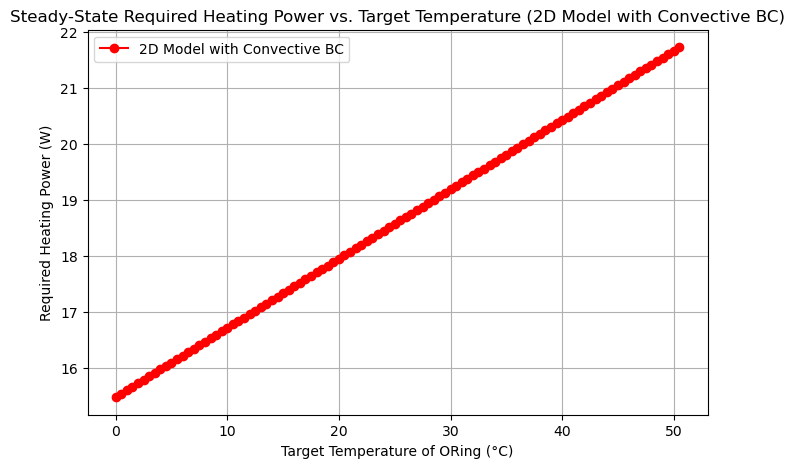

Heating Power at 19.5°C: 17.8291 W
Heating Power at 20°C: 17.9527 W
Heating Power at 21°C: 18.0764 W


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# =============================================================================
# Geometry and Discretization
# =============================================================================
L = 0.101      # [m] Total vertical extent (sphere diameter = 101 mm)
W = 0.101      # [m] Lateral extent (assuming square plate)

n_x = 100       # Number of spatial points in x-direction
n_y = 100       # Number of spatial points in y-direction
dx = L / (n_x - 1)  # Grid spacing in x
dy = W / (n_y - 1)  # Grid spacing in y

# =============================================================================
# Material Properties (Stainless Steel)
# =============================================================================
k = 16.2            # [W/m·K] thermal conductivity
rho = 7800.0        # [kg/m³] density
cp = 500.0          # [J/kg·K] specific heat
alpha = k / (rho * cp)  # [m²/s] thermal diffusivity

# =============================================================================
# Time-Stepping Parameters
# =============================================================================
dt = 0.25 * min(dx, dy) ** 2 / alpha  # Ensures stability
max_iterations = 10000  # Max iterations for steady-state convergence
tolerance = 1e-5  # Convergence threshold

# =============================================================================
# Boundary Conditions - Three-Region Model
# =============================================================================
# Fractions along the vertical extent
f_LN2 = 30 / 101   # LN2 immersion (30 mm)
f_cold = 20 / 101  # Cold air region (20 mm)
f_amb = 51 / 101   # Ambient region (51 mm)

# Region Temperatures (°C)
T_LN2  = -196.0    # Liquid nitrogen temperature
T_cold = -80.0     # Cold air temperature
T_amb  = 22.0      # Ambient temperature

# Convection Coefficients (W/m²·K)
h_LN2  = 4.827e4   # LN2 experimental value
h_cold = 10.0      # Cold air convection
h_amb  = 10.0      # Ambient air convection
h_side = 10.0      # Assumed convective coefficient for side boundaries [W/m²·K]

# =============================================================================
# Compute Corrected Effective Values
# =============================================================================
# Corrected Effective Convection Coefficient (Weighted Sum for Parallel Paths)
h_eff = f_LN2 * h_LN2 + f_cold * h_cold + f_amb * h_amb

# Corrected Effective Temperature (Weighted Average Based on Heat Transfer)
T_eff = (f_LN2 * h_LN2 * T_LN2 + f_cold * h_cold * T_cold + f_amb * h_amb * T_amb) / \
        (f_LN2 * h_LN2 + f_cold * h_cold + f_amb * h_amb)

# =============================================================================
# Heating Strip Geometry (for computing total power later)
# =============================================================================
inch = 0.0254
A_strip = inch * inch  # [m²]

# =============================================================================
# Compute Steady-State Heating Power for Different Target Temperatures (2D Case)
# =============================================================================
target_temperatures = np.arange(0, 51, 0.5)  # From 0°C to 50°C at 0.5°C intervals
steady_state_heating_powers_2D = []

# Loop over different target temperatures
for T_target in tqdm(target_temperatures, desc="Simulating for Target Temperatures (2D)"):
    # Initialize temperature grid
    T = np.full((n_x, n_y), T_amb)  # Initial condition set to ambient temperature

    for _ in range(max_iterations):
        T_new = T.copy()

        # Vectorized update of interior nodes using explicit finite-difference scheme (2D)
        T_new[1:-1, 1:-1] = T[1:-1, 1:-1] + dt * alpha * (
            (T[2:, 1:-1] - 2 * T[1:-1, 1:-1] + T[:-2, 1:-1]) / dx**2 +
            (T[1:-1, 2:] - 2 * T[1:-1, 1:-1] + T[1:-1, :-2]) / dy**2
        )

        # Apply boundary conditions
        # Bottom boundary: Robin condition (convective cooling to LN2 and air)
        T_new[0, :] = (T_new[1, :] + (dx * h_eff / k) * T_eff) / (1 + dx * h_eff / k)

        # Top boundary: Fixed temperature condition (Dirichlet BC)
        T_new[-1, :] = T_target

        # Left & Right boundaries: Convective BC instead of Neumann (insulated)
        T_new[:, 0] = (T_new[:, 1] + (dy * h_side / k) * T_amb) / (1 + dy * h_side / k)
        T_new[:, -1] = (T_new[:, -2] + (dy * h_side / k) * T_amb) / (1 + dy * h_side / k)

        # Check for steady-state (convergence)
        if np.max(np.abs(T_new - T)) < tolerance:
            break  # Stop iteration if temperature change is negligible

        T[:] = T_new  # Update temperature for next iteration

    # Compute the heating power after reaching steady-state (2D case)
    q_heater_2D = k * np.mean(abs(T[-2, :] - T_target) / dx)  # Heat flux [W/m²]
    Q_heater_2D = A_strip * q_heater_2D  # Total heating power [W]

    steady_state_heating_powers_2D.append(Q_heater_2D)  # Store result

# =============================================================================
# Plot Steady-State Heating Power vs. Target Temperature (2D)
# =============================================================================
plt.figure(figsize=(8, 5))
plt.plot(target_temperatures, steady_state_heating_powers_2D, marker='o', linestyle='-', color='red', label="2D Model with Convective BC")
plt.xlabel("Target Temperature of ORing (°C)")
plt.ylabel("Required Heating Power (W)")
plt.title("Steady-State Required Heating Power vs. Target Temperature (2D Model with Convective BC)")
plt.grid(True)
plt.legend()
plt.show()

# Print some sample values
print(f"Heating Power at 19.5°C: {steady_state_heating_powers_2D[38]:.4f} W")
print(f"Heating Power at 20°C: {steady_state_heating_powers_2D[40]:.4f} W")
print(f"Heating Power at 21°C: {steady_state_heating_powers_2D[42]:.4f} W")

Maximum Absolute error :  4.567109938847711
Minimum Absolute error :  3.4942242714323157
Absolute Error range :  1.0728856674153953
Maximum Relative error 29.503710955905575 %
Maximum Relative error 16.084668626265007 %
Relative Error range :  13.419042329640568 %


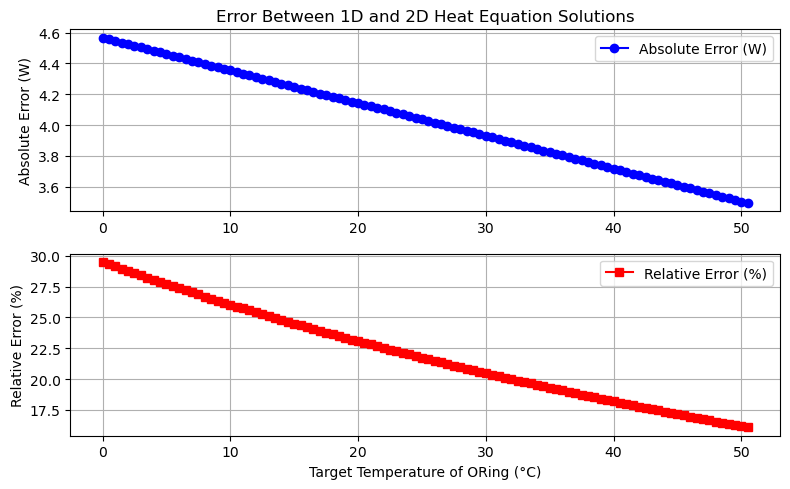

In [3]:
assert len(steady_state_heating_powers) == len(steady_state_heating_powers_2D)

Q_1D = np.array(steady_state_heating_powers)
Q_2D = np.array(steady_state_heating_powers_2D)

absolute_error = np.abs(Q_2D - Q_1D)
relative_error = (absolute_error / Q_2D) * 100

# Absolute Error plot
plt.figure(figsize=(8,5))
plt.subplot(2,1,1)
plt.plot(target_temperatures, absolute_error, marker='o', linestyle='-', color='blue', label='Absolute Error (W)')
plt.ylabel("Absolute Error (W)")
plt.title("Error Between 1D and 2D Heat Equation Solutions")
plt.grid(True)
plt.legend()
print("Maximum Absolute error : ", max(absolute_error))
print("Minimum Absolute error : ", min(absolute_error))
print("Absolute Error range : ", max(absolute_error) - min(absolute_error))

# Relative error plot
plt.subplot(2, 1, 2)
plt.plot(target_temperatures, relative_error, marker='s', linestyle='-', color='red', label="Relative Error (%)")
plt.xlabel("Target Temperature of ORing (°C)")
plt.ylabel("Relative Error (%)")
plt.grid(True)
plt.legend()
print("Maximum Relative error", max(relative_error),"%")
print("Maximum Relative error", min(relative_error),"%")
print("Relative Error range : ", max(relative_error) - min(relative_error),"%")

plt.tight_layout()
plt.show()
         

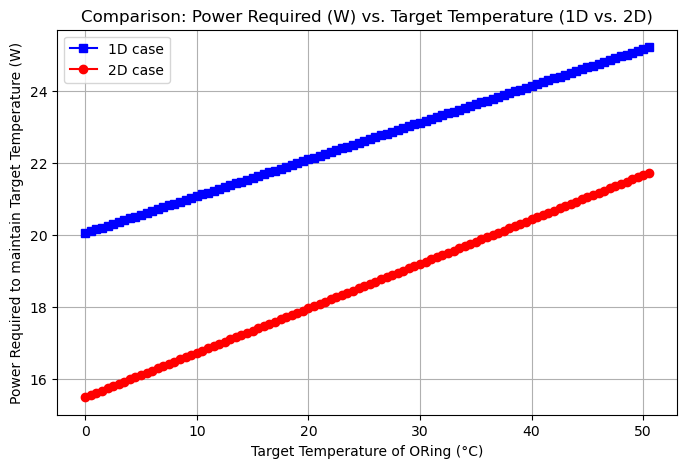

In [4]:
plt.figure(figsize=(8, 5))
plt.plot(target_temperatures, steady_state_heating_powers, marker='s', linestyle='-', color='blue', label="1D case")
plt.plot(target_temperatures, steady_state_heating_powers_2D, marker='o', linestyle='-', color='red', label="2D case")

plt.xlabel("Target Temperature of ORing (°C)")
plt.ylabel("Power Required to maintain Target Temperature (W)")
plt.title("Comparison: Power Required (W) vs. Target Temperature (1D vs. 2D)")
plt.grid(True)
plt.legend()
plt.show()

There is a clear pattern in the error if we vary the number of nodes $n_x$ and $n_y$ used. The trend is as follows: 

- If $n_x = n_y$ = 50, then the 1D case and 2D case yield extremely identical results, with a very low relative and absolute error. Can we assume that the 2D case converges (to some degree of agreement) to the 1D case. There is very weird shift in the error between the 2 cases spiking at the 20 degree mark. The relative error seems to peak at 21 degrees and then decreases as $T$ increases. However, the absolute error does not seem to decrease, it either platued, or might be increasing at a very slow rate (need to expand the range of $T$ to investigate more).
  
- If $n_x = n_y$ >> 50, then the 2D case clearly diverges from the 1D case (as shown above). The relative error/ absolute error increases rapidy, however, the weird shift in error around the 20 degree mark vanishes and both error functions seems to be decreasing rapidly as well. 


Computing Heat Flux (2D with Convective BC): 100%|██████████| 102/102 [01:59<00:00,  1.18s/it]


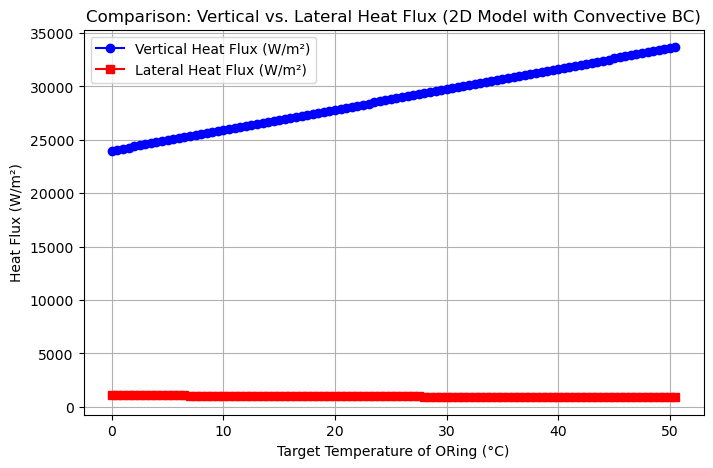

In [5]:
# Define new convective boundary conditions for the lateral walls
h_side = 10.0  # Assumed convective heat transfer coefficient for side boundaries [W/m²·K]
T_side = T_amb  # Assume ambient temperature at side boundaries

# Initialize storage for heat flux values
vertical_heat_flux_2D_conv = []
lateral_heat_flux_2D_conv = []

# Loop over different target temperatures
for T_target in tqdm(target_temperatures, desc="Computing Heat Flux (2D with Convective BC)"):
    # Initialize temperature grid
    T = np.full((n_x, n_y), T_amb)  # Initial condition set to ambient temperature

    for _ in range(max_iterations):
        T_new = T.copy()

        # Vectorized update of interior nodes using explicit finite-difference scheme (2D)
        T_new[1:-1, 1:-1] = T[1:-1, 1:-1] + dt * alpha * (
            (T[2:, 1:-1] - 2 * T[1:-1, 1:-1] + T[:-2, 1:-1]) / dx**2 +
            (T[1:-1, 2:] - 2 * T[1:-1, 1:-1] + T[1:-1, :-2]) / dy**2
        )

        # Apply boundary conditions
        # Bottom boundary: Robin condition (convective cooling to LN2 and air)
        T_new[0, :] = (T_new[1, :] + (dx * h_eff / k) * T_eff) / (1 + dx * h_eff / k)

        # Top boundary: Fixed temperature condition (Dirichlet BC)
        T_new[-1, :] = T_target

        # Left & Right boundaries: Convective BC instead of Neumann
        T_new[:, 0] = (T_new[:, 1] + (dy * h_side / k) * T_side) / (1 + dy * h_side / k)
        T_new[:, -1] = (T_new[:, -2] + (dy * h_side / k) * T_side) / (1 + dy * h_side / k)

        # Check for steady-state (convergence)
        if np.max(np.abs(T_new - T)) < tolerance:
            break  # Stop iteration if temperature change is negligible

        T[:] = T_new  # Update temperature for next iteration

    # Compute Vertical and Lateral Heat Flux
    q_vertical_conv = k * np.mean(abs(T[-2, :] - T_target) / dx)  # Heat flux in x-direction [W/m²]
    q_lateral_conv = k * np.mean(abs(T[:, -2] - T[:, -1]) / dy)   # Heat flux in y-direction [W/m²]

    vertical_heat_flux_2D_conv.append(q_vertical_conv)
    lateral_heat_flux_2D_conv.append(q_lateral_conv)

# =============================================================================
# Plot Vertical vs. Lateral Heat Flux for 2D Model (With Convective BC)
# =============================================================================
plt.figure(figsize=(8, 5))
plt.plot(target_temperatures, vertical_heat_flux_2D_conv, marker='o', linestyle='-', color='blue', label="Vertical Heat Flux (W/m²)")
plt.plot(target_temperatures, lateral_heat_flux_2D_conv, marker='s', linestyle='-', color='red', label="Lateral Heat Flux (W/m²)")

plt.xlabel("Target Temperature of ORing (°C)")
plt.ylabel("Heat Flux (W/m²)")
plt.title("Comparison: Vertical vs. Lateral Heat Flux (2D Model with Convective BC)")
plt.grid(True)
plt.legend()
plt.show()


In the 2D case, we can see that the vertical heat flux has a steeper gradient compared to the horizontal heat flux. This means that the dominant flow of heat is along the vertical axis on the sphere. This makes sense since the cooling from $LN_2$ is much greater than the cooling done by the cold air around the sphere, which we can approximate to being equally cool on all sides of the sphere in that region (boundary condition). Further imporvements can be made to the model when we strictly enforce the spherical geometry in the calculations. As $T_{target}$ increases, more energy flows from top to bottom, then side to side. 

Simulating for Convective BC (Side Walls): 100%|██████████| 102/102 [01:58<00:00,  1.16s/it]


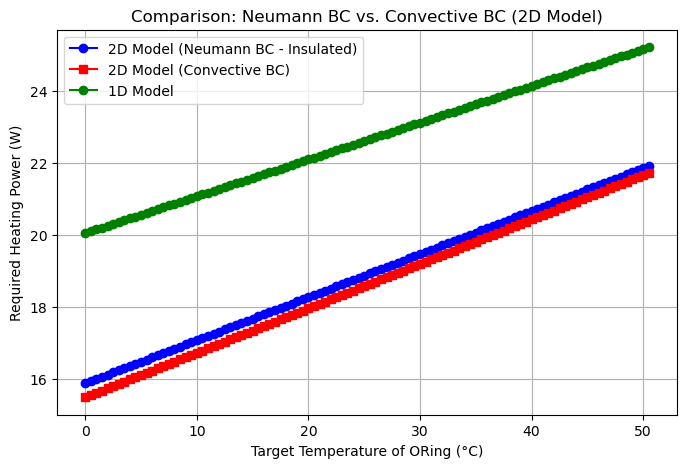

Heating Power at 19°C: 18.1454 W
Heating Power at 20°C: 18.2652 W
Heating Power at 21°C: 18.3850 W
Heating Power at 19°C: 17.8291 W
Heating Power at 20°C: 17.9527 W
Heating Power at 21°C: 18.0764 W


In [6]:
target_temperatures = np.arange(0, 51, 0.5)  # From 0°C to 50°C at 0.5°C intervals
steady_state_heating_powers_2D_neumann = []
steady_state_heating_powers_2D_conv = []

# Run simulation for Neumann BC case
for T_target in tqdm(target_temperatures, desc="Simulating for Neumann BC (Insulated Walls)"):
    # Initialize temperature grid
    T = np.full((n_x, n_y), T_amb)  # Initial condition set to ambient temperature

    for _ in range(max_iterations):
        T_new = T.copy()

        # Vectorized update of interior nodes using explicit finite-difference scheme (2D)
        T_new[1:-1, 1:-1] = T[1:-1, 1:-1] + dt * alpha * (
            (T[2:, 1:-1] - 2 * T[1:-1, 1:-1] + T[:-2, 1:-1]) / dx**2 +
            (T[1:-1, 2:] - 2 * T[1:-1, 1:-1] + T[1:-1, :-2]) / dy**2
        )

        # Apply boundary conditions
        # Bottom boundary: Robin condition (convective cooling to LN2 and air)
        T_new[0, :] = (T_new[1, :] + (dx * h_eff / k) * T_eff) / (1 + dx * h_eff / k)

        # Top boundary: Fixed temperature condition (Dirichlet BC)
        T_new[-1, :] = T_target

        # Left & Right boundaries: Neumann BC (insulated walls)
        T_new[:, 0] = T_new[:, 1]  # dT/dx = 0
        T_new[:, -1] = T_new[:, -2]  # dT/dx = 0

        # Check for steady-state (convergence)
        if np.max(np.abs(T_new - T)) < tolerance:
            break

        T[:] = T_new

    # Compute heating power (2D case with Neumann BC)
    q_heater_2D_neumann = k * np.mean(abs(T[-2, :] - T_target) / dx)  # Heat flux [W/m²]
    Q_heater_2D_neumann = A_strip * q_heater_2D_neumann  # Total heating power [W]
    steady_state_heating_powers_2D_neumann.append(Q_heater_2D_neumann)

# Run simulation for Convective BC case
for T_target in tqdm(target_temperatures, desc="Simulating for Convective BC (Side Walls)"):
    # Initialize temperature grid
    T = np.full((n_x, n_y), T_amb)

    for _ in range(max_iterations):
        T_new = T.copy()

        # Vectorized update of interior nodes using explicit finite-difference scheme (2D)
        T_new[1:-1, 1:-1] = T[1:-1, 1:-1] + dt * alpha * (
            (T[2:, 1:-1] - 2 * T[1:-1, 1:-1] + T[:-2, 1:-1]) / dx**2 +
            (T[1:-1, 2:] - 2 * T[1:-1, 1:-1] + T[1:-1, :-2]) / dy**2
        )

        # Apply boundary conditions
        # Bottom boundary: Robin condition (convective cooling to LN2 and air)
        T_new[0, :] = (T_new[1, :] + (dx * h_eff / k) * T_eff) / (1 + dx * h_eff / k)

        # Top boundary: Fixed temperature condition (Dirichlet BC)
        T_new[-1, :] = T_target

        # Left & Right boundaries: Convective BC instead of Neumann
        T_new[:, 0] = (T_new[:, 1] + (dy * h_side / k) * T_amb) / (1 + dy * h_side / k)
        T_new[:, -1] = (T_new[:, -2] + (dy * h_side / k) * T_amb) / (1 + dy * h_side / k)

        # Check for steady-state (convergence)
        if np.max(np.abs(T_new - T)) < tolerance:
            break

        T[:] = T_new

    # Compute heating power (2D case with Convective BC)
    q_heater_2D_conv = k * np.mean(abs(T[-2, :] - T_target) / dx)
    Q_heater_2D_conv = A_strip * q_heater_2D_conv
    steady_state_heating_powers_2D_conv.append(Q_heater_2D_conv)

# =============================================================================
# Plot Comparison: Convective BC vs. Neumann BC (Insulated Walls)
# =============================================================================
plt.figure(figsize=(8, 5))
plt.plot(target_temperatures, steady_state_heating_powers_2D_neumann, marker='o', linestyle='-', color='blue', label="2D Model (Neumann BC - Insulated)")
plt.plot(target_temperatures, steady_state_heating_powers_2D_conv, marker='s', linestyle='-', color='red', label="2D Model (Convective BC)")
plt.plot(target_temperatures, steady_state_heating_powers, marker='o', linestyle='-', color='green', label = "1D Model")

plt.xlabel("Target Temperature of ORing (°C)")
plt.ylabel("Required Heating Power (W)")
plt.title("Comparison: Neumann BC vs. Convective BC (2D Model)")
plt.grid(True)
plt.legend()
plt.show()

# Print some sample values
print(f"Heating Power at 19°C: {steady_state_heating_powers_2D_neumann[38]:.4f} W")
print(f"Heating Power at 20°C: {steady_state_heating_powers_2D_neumann[40]:.4f} W")
print(f"Heating Power at 21°C: {steady_state_heating_powers_2D_neumann[42]:.4f} W")

print(f"Heating Power at 19°C: {steady_state_heating_powers_2D_conv[38]:.4f} W")
print(f"Heating Power at 20°C: {steady_state_heating_powers_2D_conv[40]:.4f} W")
print(f"Heating Power at 21°C: {steady_state_heating_powers_2D_conv[42]:.4f} W")

Maximum Absolute error in 2D case:  0.3895684173959051
Minimum Absolute error in 2D case:  0.1950287823924377
Absolute Error range in 2D case:  0.19453963500346738
Maximum Relative error in 2D case 2.5166273941936774 %
Maximum Relative error in 2D case 0.8977595865878503 %
Relative Error range in 2D case:  1.6188678076058272 %


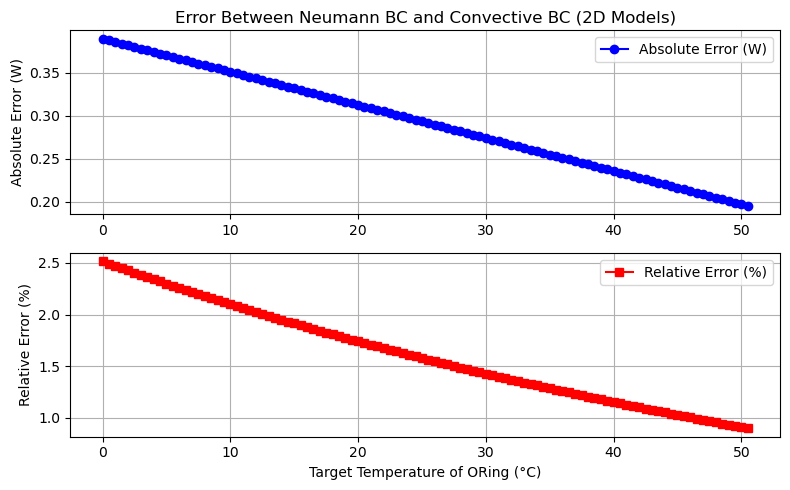

In [7]:
assert len(steady_state_heating_powers_2D_conv) == len(steady_state_heating_powers_2D_neumann), "Error: Lists must be the same length."

# Convert lists to NumPy arrays for efficient computation
Q_conv = np.array(steady_state_heating_powers_2D_conv)
Q_neumann = np.array(steady_state_heating_powers_2D_neumann)

# Compute Absolute and Relative Errors
absolute_error_2D = np.abs(Q_conv - Q_neumann)  # |Q_conv - Q_neumann|
relative_error_2D = (absolute_error_2D / Q_conv) * 100  # Relative error in %

# =============================================================================
# Plot Absolute and Relative Errors for 2D Models
# =============================================================================
plt.figure(figsize=(8, 5))


# Absolute Error Plot
plt.subplot(2, 1, 1)
plt.plot(target_temperatures, absolute_error_2D, marker='o', linestyle='-', color='blue', label="Absolute Error (W)")
plt.ylabel("Absolute Error (W)")
plt.title("Error Between Neumann BC and Convective BC (2D Models)")
plt.grid(True)
plt.legend()
print("Maximum Absolute error in 2D case: ", max(absolute_error_2D))
print("Minimum Absolute error in 2D case: ", min(absolute_error_2D))
print("Absolute Error range in 2D case: ", max(absolute_error_2D) - min(absolute_error_2D))

# Relative Error Plot
plt.subplot(2, 1, 2)
plt.plot(target_temperatures, relative_error_2D, marker='s', linestyle='-', color='red', label="Relative Error (%)")
plt.xlabel("Target Temperature of ORing (°C)")
plt.ylabel("Relative Error (%)")
plt.grid(True)
plt.legend()
print("Maximum Relative error in 2D case", max(relative_error_2D),"%")
print("Maximum Relative error in 2D case", min(relative_error_2D),"%")
print("Relative Error range in 2D case: ", max(relative_error_2D) - min(relative_error_2D),"%")

plt.tight_layout()
plt.show()
